<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [7]:
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [8]:
import string

sentences = []
word_threshold = 32

for sentence in tqdm(dataset['train']['text']):
    text_sentences = sent_tokenize(sentence, language='english')
    sent_words_tk = filter(lambda x: len(x) < word_threshold, [word_tokenize(x.lower().translate(str.maketrans('', '', string.punctuation))) for x in text_sentences])
    sentences.extend(sent_words_tk)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [9]:
print("Всего предложений:", len(sentences))

Всего предложений: 220283


Посчитаем для каждого слова его встречаемость.

In [10]:
words = Counter()

for sentence in sentences:
    for word in sentence:
        words[word] += 1

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [11]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

vocab |= set(map(lambda x: x[0], sorted(words.items(), key=lambda x: x[1], reverse=True)[:vocab_size]))

In [12]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [13]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [14]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [15]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in self.data[idx]
            ]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [16]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [17]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [18]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [19]:
def train_model(model, optimizer, criterion, num_epoch):
    losses = []
    perplexities = []
    for epoch in range(num_epoch):
        torch.cuda.empty_cache()
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
            optimizer.zero_grad()
            input_ids, target_ids = batch['input_ids'], batch['target_ids']
            logits = model(input_ids).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, target_ids.flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))
    return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [20]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        x = self.embedding(input_batch)
        x, _ = self.rnn(x)
        x = self.dropout(self.linear(self.non_lin(x)))
        x = self.projection(self.non_lin(x))
        return x

In [21]:
model = LanguageModel(hidden_dim=128, vocab_size=vocab_size+4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [31]:
torch.cuda.empty_cache()

In [32]:
epochs = 10
losses, perplexities = train_model(model, optimizer, criterion, epochs)

Epoch 1:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/5508 [00:00<?, ?it/s]

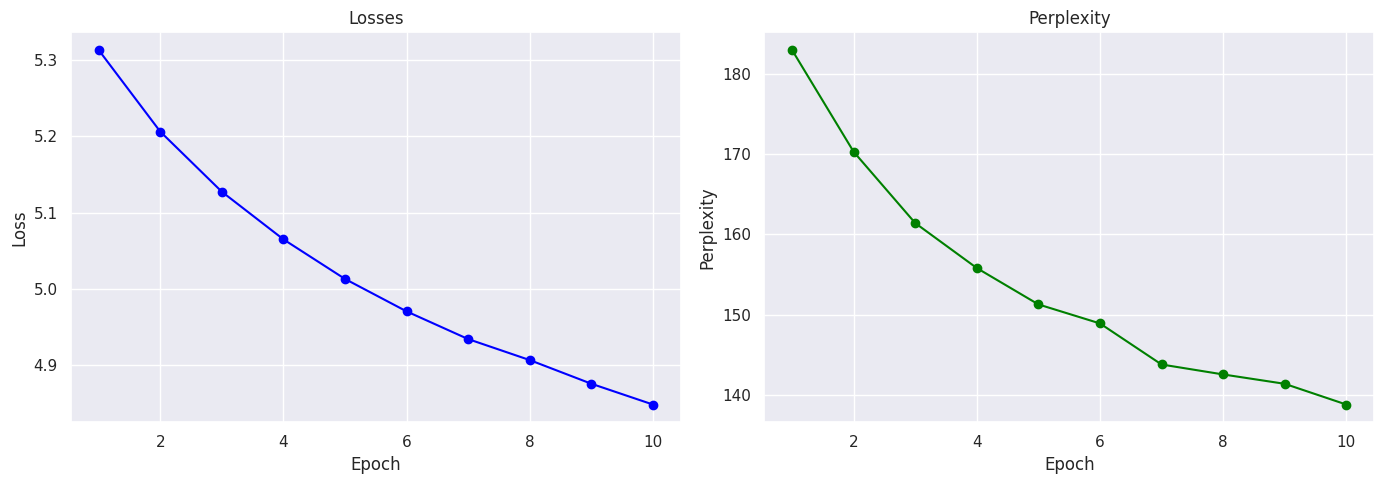

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, epochs+1), losses, marker='o', color='blue')
ax1.set_title('Losses')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(range(1, epochs+1), perplexities, marker='o', color='green')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [35]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        x = self.embedding(input_batch)
        x, _ = self.rnn(x)
        x = self.dropout(self.linear(self.non_lin(x)))
        x = self.projection(self.non_lin(x))
        return x

In [36]:
torch.cuda.empty_cache()

In [37]:
model = LSTMLanguageModel(hidden_dim=128, vocab_size=vocab_size+4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [38]:
epochs = 15
losses, perplexities = train_model(model, optimizer, criterion, epochs)

Epoch 1:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/5508 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/5508 [00:00<?, ?it/s]

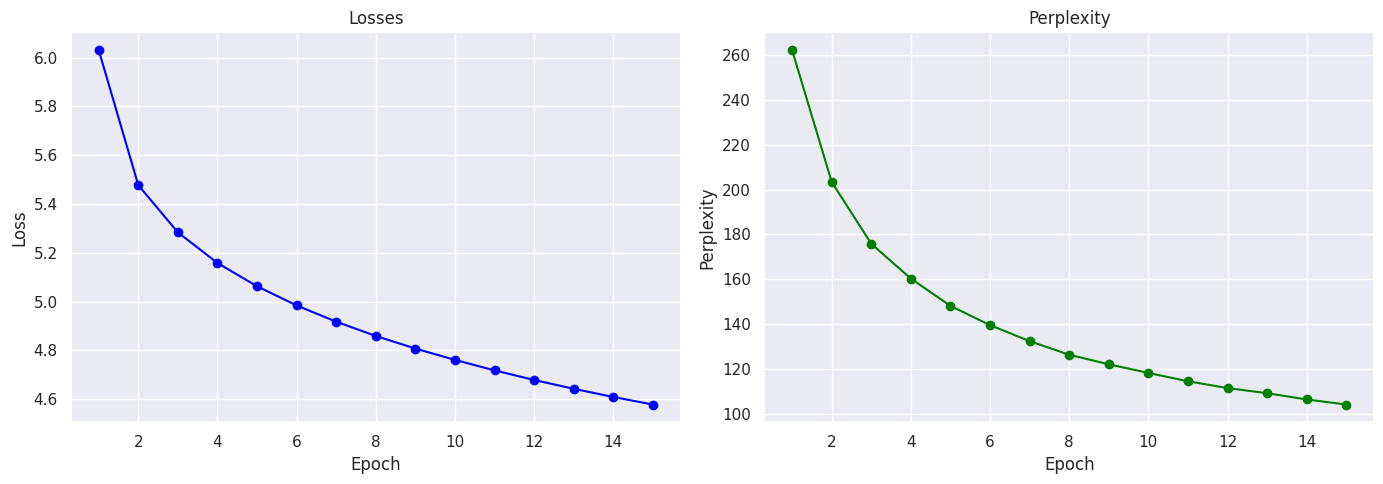

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, epochs+1), losses, marker='o', color='blue')
ax1.set_title('Losses')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(range(1, epochs+1), perplexities, marker='o', color='green')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [41]:
min(perplexities)

104.17216125523746

In [45]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

generate_sequence(model, starting_seq='this horror movie')

'<bos> this horror movie is a little bit of a movie that is not a good movie <eos>'

дэмн...

### Отчет (2 балла)

В ходе работы я обучал рекуррентные сети для задачи предсказания следующего слова в тексте. Проверял две архитектуры: классическую RNN и более сложную версию с LSTM. Для LSTM я провел 15 эпох обучения, а для RNN — 10 эпох. При этом перплексия для обеих моделей не достигла плато, что говорит о том, что модели ещё могли бы улучшиться при дополнительном обучении.

Сравнивая результаты, я заметил, что LSTM показала более низкие значения перплексии, что связано с её способностью лучше учитывать долгосрочные зависимости в последовательностях данных. RNN, в свою очередь, при более простом устройстве и меньших ресурсных затратах, продемонстрировала менее точные предсказания за отведённое время обучения.

Для дальнейшего улучшения моделей я бы предложил увеличить количество эпох, экспериментировать с гиперпараметрами — например, размером скрытых слоев, количеством слоев, а также использовать более продвинутые архитектуры, такие как GRU или двунаправленные рекуррентные сети. Помимо этого, имеет смысл применить методы регуляризации, обучать модель с изменяющейся скоростью обучения и разнообразить тренировочные данные.

В целом, проведённые эксперименты подтвердили, что LSTM — более эффективный выбор для моделирования языковых данных, но обе архитектуры обладают потенциалом для улучшения при дальнейшем обучении и оптимизации.